In [1]:
# System tools
import scipy.misc
import random
import time
import sys
import os
import numpy as np

# Pytorch
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

# Image I/O
import cv2
import PIL
from  matplotlib import pyplot as plt

# Analysis
from sklearn.metrics import confusion_matrix
import pandas as pd

%matplotlib inline

In [2]:
def check_and_create_folder(directory):
    try:
        os.stat(directory)
        print ('folder: ', directory, 'exits, do you want to remove it')
    except:
        os.mkdir(directory)
        print ('create ', directory)

# UNet train

### Hyper parameters

In [9]:
INPUT_IMG_SIZE = (480, 640)             # HEIGHT, WIDTH
BATCH_SIZE   = 3
NUM_EPOCHS   = 1000
NUM_WROKERS  = 0
LR           = 1e-4
MOMENTUM     = 0
WEIGHT_DECAY = 1e-5
STEP_SIZE    = 50
GAMMA        = 0.5
DATASET_ROOT = "./shoes_dataset_folder"
MODELS_ROOT  = "./models"
CLASSES = ["background", "right_shoes", "left_shoes"]    # classes with 'background' element
BACKBONE = "resnet34"

MASKS_DIR    = os.path.join(DATASET_ROOT, "masks")
LABELS_DIR   = os.path.join(DATASET_ROOT, "labels")
IMAGES_DIR   = os.path.join(DATASET_ROOT, "images")
if not os.path.isdir(MODELS_ROOT):
    os.mkdir(MODELS_ROOT)
NUM_CLASSES = len(CLASSES)

In [4]:
data_list = pd.read_csv(os.path.join(DATASET_ROOT, "train.csv"))
data_list

,images/angle0_25.jpg,masks/angle0_25.png
0,images/angle0_86.jpg,masks/angle0_86.png
1,images/angle0_4.jpg,masks/angle0_4.png
2,images/angle0_99.jpg,masks/angle0_99.png
3,images/angle0_84.jpg,masks/angle0_84.png
4,images/angle0_13.jpg,masks/angle0_13.png
...,...,...
74,images/angle0_5.jpg,masks/angle0_5.png
75,images/angle0_16.jpg,masks/angle0_16.png
76,images/angle0_9.jpg,masks/angle0_9.png
77,images/angle0_73.jpg,masks/angle0_73.png


In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataset_csv_file, phase):
        
        self.data_list = pd.read_csv(dataset_csv_file)
        
        print("********** Dataset Info start **********\n")
        print("Source: " + dataset_csv_file)
        print("Classes: {}".format(CLASSES))
        print("Amount of data: {}".format(len(self.data_list)))
        print("\n*********** Dataset Info end ***********\n")
        
        self.data_transform = transforms.Compose([
                                transforms.ToPILImage(), \
                                transforms.Resize(INPUT_IMG_SIZE), \
                                transforms.ToTensor(), \
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                                ])
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        image_path   = self.data_list.iloc[index, 0]
        mask_path    = self.data_list.iloc[index, 1]
        
        # Read image
        # image_raw = self.default_loader(os.path.join(DATASET_ROOT, image_path))
        image_raw = cv2.imread(os.path.join(DATASET_ROOT, image_path))
        input_image = self.data_transform(image_raw)
        # Read mask
        # mask_raw = PIL_Image.open(mask_path).convert('LA')
        mask_raw = cv2.imread(os.path.join(DATASET_ROOT, mask_path), cv2.IMREAD_GRAYSCALE)
        mask_raw = cv2.resize(mask_raw, (INPUT_IMG_SIZE[1], INPUT_IMG_SIZE[0]))
        mask_each_classes = torch.zeros(NUM_CLASSES, INPUT_IMG_SIZE[0], INPUT_IMG_SIZE[1])
        for i in range(NUM_CLASSES):
            mask_each_classes[i][mask_raw == i] = 1
        batch = {'input': input_image, 'target': mask_each_classes, 'mask_raw':mask_raw, 'image_raw': image_raw}
        # batch = {'input': input_image, 'target': mask_each_classes}
        return batch
    
    def pil_loader(self, path):
        with open(path, "rb") as f:
            with PIL.Image.open(f) as img:
                return img.convert("RGB")

    def accimage_loader(self, path):
        try:
            return accimage.Image(path)
        except IOError:
            # Potentially a decoding problem, fall back to PIL.Image
            return pil_loader(path)

    def default_loader(self, path):
        if torchvision.get_image_backend() == "accimage":
            return self.accimage_loader(path)
        else:
            return self.pil_loader(path)

In [6]:
# Training data loader
train_csv_path   = os.path.join(DATASET_ROOT, "train.csv")
train_dataset    = CustomDataset(dataset_csv_file=train_csv_path, phase="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WROKERS)

# Testing data loader
test_csv_path   = os.path.join(DATASET_ROOT, "test.csv")
test_dataset    = CustomDataset(dataset_csv_file=test_csv_path, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0)

********** Dataset Info start **********

Source: ./shoes_dataset_folder\train.csv
Classes: ['background', 'right_shoes', 'left_shoes']
Amount of data: 79

*********** Dataset Info end ***********

********** Dataset Info start **********

Source: ./shoes_dataset_folder\test.csv
Classes: ['background', 'right_shoes', 'left_shoes']
Amount of data: 8

*********** Dataset Info end ***********



In [10]:
# Load model
model = smp.Unet(BACKBONE, classes=NUM_CLASSES, activation='softmax', encoder_weights='imagenet')
model.cuda()

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA) 

In [12]:
def train(model, optimizer, scheduler, loss_list, model_name):
    for epoch in range(NUM_EPOCHS):
        model.train()
        configs    = "resnetunet_{}_batch{}_epoch{}_RMSprop_lr{}".format(model_name, BATCH_SIZE, epoch, LR)
        model_path = os.path.join(MODELS_ROOT, configs)
        
        for index, batch in enumerate(train_dataloader):
            optimizer.zero_grad()

            if torch.cuda.is_available():
                inputs = batch['input'].cuda()
                targets = batch['target'].cuda()
            else:
                inputs, targets = batch['X'], batch['Y']

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
            if index % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, index, loss))
                # print(loss)
  
        scheduler.step()
        loss_list.append(loss)
        print("==== Finish epoch {} ====".format(epoch))
        if epoch % 50 == 0:
            torch.save(model.state_dict(), model_path + '.pkl')
        # val(epoch)

In [ ]:
loss_list = []
train(model, optimizer, scheduler, loss_list, model_name=BACKBONE)

D:\anaconda3\envs\Pytorch\lib\site-packages\segmentation_models_pytorch\base\modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


epoch0, iter0, loss: 0.7573525309562683
epoch0, iter10, loss: 0.6625019311904907
epoch0, iter20, loss: 0.6424121856689453
==== Finish epoch 0 ====
epoch1, iter0, loss: 0.6411194205284119
epoch1, iter10, loss: 0.6235353350639343
epoch1, iter20, loss: 0.6208093166351318
==== Finish epoch 1 ====
epoch2, iter0, loss: 0.6156893372535706
epoch2, iter10, loss: 0.6104102730751038
epoch2, iter20, loss: 0.6099702715873718
==== Finish epoch 2 ====
epoch3, iter0, loss: 0.6018610000610352
epoch3, iter10, loss: 0.5971440076828003
epoch3, iter20, loss: 0.5934694409370422
==== Finish epoch 3 ====
epoch4, iter0, loss: 0.5935572981834412
epoch4, iter10, loss: 0.5907052159309387
epoch4, iter20, loss: 0.6069134473800659
==== Finish epoch 4 ====
epoch5, iter0, loss: 0.5927122831344604
epoch5, iter10, loss: 0.5907849669456482
epoch5, iter20, loss: 0.5851207375526428
==== Finish epoch 5 ====
epoch6, iter0, loss: 0.5835727453231812
epoch6, iter10, loss: 0.5837199687957764
epoch6, iter20, loss: 0.5806581974029

In [37]:
test(model)

(3, 3, 480, 640)


ValueError: cannot reshape array of size 921600 into shape (307200,)

In [54]:
def prediction(model, model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(MODELS_ROOT, model_name))
    model.load_state_dict(state_dict)
    
    # dataiter = iter(test_dataloader)
    # batch = dataiter.next()
    for index, batch in enumerate(test_dataloader):
        if torch.cuda.is_available:
            inputs = batch['input'].cuda()
        else:
            inputs = batch['input']
        img    = batch['image_raw']
        label  = batch['target']
        mask_raw = batch['mask_raw']

        with torch.no_grad():
            outputs = model(inputs)
            outputs = outputs.data.cpu().numpy()

        N, _, h, w = outputs.shape
        pred = outputs.transpose(0, 2, 3, 1).reshape(-1, NUM_CLASSES).argmax(axis = 1).reshape(N, h, w)

        # show images
        plt.figure(figsize = (10, 12))
        img = img.numpy()
        for i in range(N):
            img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
            plt.subplot(N, 3, i*3 + 1)
            plt.title("origin_img")
            plt.imshow(img[i])
            #print(np.unique(_img[i]))

            plt.subplot(N, 3, i*3 + 2)
            plt.title("label_img")
            plt.imshow(mask_raw[i],cmap = "brg",vmin = 0, vmax = NUM_CLASSES - 1)

            plt.subplot(N, 3, i*3 + 3)
            plt.title("prediction")
            plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = NUM_CLASSES - 1)

        plt.show()

D:\anaconda3\envs\Pytorch\lib\site-packages\segmentation_models_pytorch\base\modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


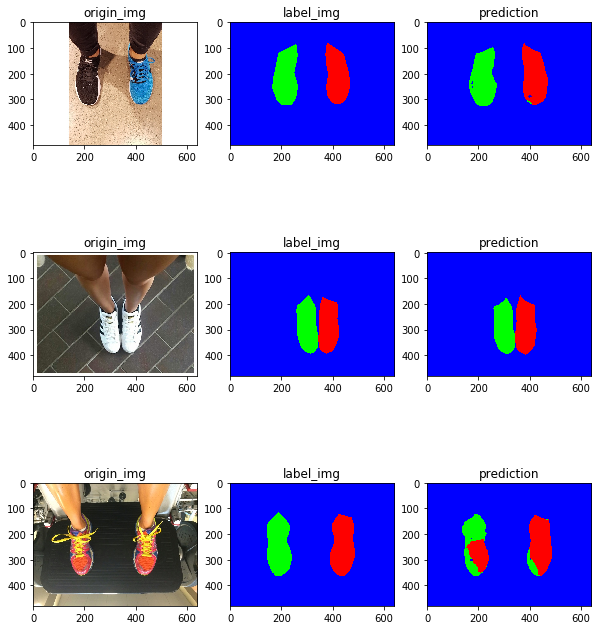

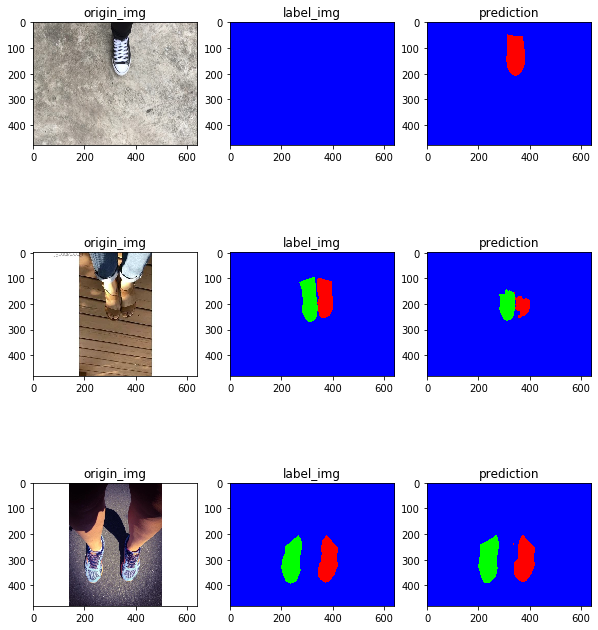

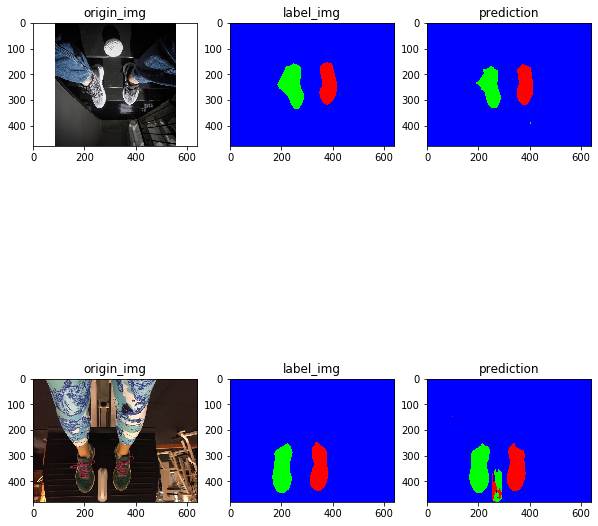

In [55]:
prediction(model, "FCN_resnet18_batch3_epoch200_RMSprop_lr0.0001.pkl")